<a href="https://colab.research.google.com/github/MLP-deepdreamteam/Practice_captioning/blob/branch_%EB%B0%B1%EC%9A%B4%EC%B2%A0/custom2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

> Image captioning is the task of generating textual descriptions of a given image, requiring  techniques of computer vision and natural language processing.

It is a popular research area of Artificial Intelligence that deals with image understanding and a language description for that image. Generating well-formed sentences requires both syntactic and semantic understanding of the language. Being able to describe the content of an image using accurately formed sentences is a very challenging task, but it could also have a great impact, by helping visually impaired people better understand the content of images.  [source](https://www.analyticsvidhya.com/blog/2020/11/create-your-own-image-caption-generator-using-keras/) 

Here, I have used [COCO Dataset 2017](https://cocodataset.org/#download) which contains **12 different types of categories** and among them it has **80 types of sub-categories**. Each sub categories contain list of images and five captions to each image.

In [ ]:
 !pip install pycocotools

from pycocotools.coco import COCO # COCO python library
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

import random
import string

import cv2
import os
from pickle import dump, load
import json

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from keras.layers import add

from tensorflow.keras.models import Model, load_model

# small library for seeing the progress of loops.
from tqdm.notebook import tqdm

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Exploring COCO Dataset

#### Initialize COCO class and operate instances_train2017.json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
coco=COCO("/content/drive/MyDrive/coco_dataset/coco_ann2017/annotations/instances_train2017.json")




loading annotations into memory...
Done (t=34.44s)
creating index...
index created!


In [ ]:


with open(f'/content/drive/MyDrive/coco_dataset/coco_ann2017/annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
captions['image'] = captions['image'].apply(
    lambda x: f'/content/drive/MyDrive/coco_dataset//train2017/{x}'
)
captions = captions.sample(70000)
captions = captions.reset_index(drop=True)
captions.head()

In [ ]:



new_tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions['caption'])


In [ ]:
#### Find Categories

In [ ]:
cats = coco.loadCats(coco.getCatIds())
maincategories = list(set([cat['supercategory'] for cat in cats]))

print("Number of main categories: ", len(maincategories))
print("List of main categories: ", maincategories)

Number of main categories:  12
List of main categories:  ['outdoor', 'animal', 'vehicle', 'kitchen', 'indoor', 'food', 'accessory', 'person', 'sports', 'appliance', 'furniture', 'electronic']


#### Find Sub Categories

In [ ]:
subcategories = [cat['name'] for cat in cats]

print("Number of sub categories: ", len(subcategories))
print("List of sub categories: ", subcategories)

Number of sub categories:  80
List of sub categories:  ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


#### Find Sub categories with its corresponding IDs

In [ ]:
catIds = coco.getCatIds(catNms=subcategories)

subcategories_Ids = dict()
for i in range(0,len(subcategories)):
    subcategories_Ids[subcategories[i]] = catIds[i]

print("Sub categories with IDs :",subcategories_Ids)

Sub categories with IDs : {'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'airplane': 5, 'bus': 6, 'train': 7, 'truck': 8, 'boat': 9, 'traffic light': 10, 'fire hydrant': 11, 'stop sign': 13, 'parking meter': 14, 'bench': 15, 'bird': 16, 'cat': 17, 'dog': 18, 'horse': 19, 'sheep': 20, 'cow': 21, 'elephant': 22, 'bear': 23, 'zebra': 24, 'giraffe': 25, 'backpack': 27, 'umbrella': 28, 'handbag': 31, 'tie': 32, 'suitcase': 33, 'frisbee': 34, 'skis': 35, 'snowboard': 36, 'sports ball': 37, 'kite': 38, 'baseball bat': 39, 'baseball glove': 40, 'skateboard': 41, 'surfboard': 42, 'tennis racket': 43, 'bottle': 44, 'wine glass': 46, 'cup': 47, 'fork': 48, 'knife': 49, 'spoon': 50, 'bowl': 51, 'banana': 52, 'apple': 53, 'sandwich': 54, 'orange': 55, 'broccoli': 56, 'carrot': 57, 'hot dog': 58, 'pizza': 59, 'donut': 60, 'cake': 61, 'chair': 62, 'couch': 63, 'potted plant': 64, 'bed': 65, 'dining table': 67, 'toilet': 70, 'tv': 72, 'laptop': 73, 'mouse': 74, 'remote': 75, 'keyboard': 76, 'c

#### Find total images with each sub categories

In [ ]:
subcategories_imageIds = dict()

for i in range(0,len(catIds)):
    imgIds = coco.getImgIds(catIds=catIds[i])
    img = []
    for j in imgIds: 
        img.append(j)
    subcategories_imageIds[subcategories[i]] = img
    
print("Sub categories with Image IDs :",len(subcategories_imageIds))

Sub categories with Image IDs : 80


In [ ]:
length_dict = {key: len(value) for key, value in subcategories_imageIds.items()}
print("Total images in each sub categories: ", length_dict)

Total images in each sub categories:  {'person': 64115, 'bicycle': 3252, 'car': 12251, 'motorcycle': 3502, 'airplane': 2986, 'bus': 3952, 'train': 3588, 'truck': 6127, 'boat': 3025, 'traffic light': 4139, 'fire hydrant': 1711, 'stop sign': 1734, 'parking meter': 705, 'bench': 5570, 'bird': 3237, 'cat': 4114, 'dog': 4385, 'horse': 2941, 'sheep': 1529, 'cow': 1968, 'elephant': 2143, 'bear': 960, 'zebra': 1916, 'giraffe': 2546, 'backpack': 5528, 'umbrella': 3968, 'handbag': 6841, 'tie': 3810, 'suitcase': 2402, 'frisbee': 2184, 'skis': 3082, 'snowboard': 1654, 'sports ball': 4262, 'kite': 2261, 'baseball bat': 2506, 'baseball glove': 2629, 'skateboard': 3476, 'surfboard': 3486, 'tennis racket': 3394, 'bottle': 8501, 'wine glass': 2533, 'cup': 9189, 'fork': 3555, 'knife': 4326, 'spoon': 3529, 'bowl': 7111, 'banana': 2243, 'apple': 1586, 'sandwich': 2365, 'orange': 1699, 'broccoli': 1939, 'carrot': 1683, 'hot dog': 1222, 'pizza': 3166, 'donut': 1523, 'cake': 2925, 'chair': 12774, 'couch': 44

In [ ]:
#subcategories_imageIds['bicycle']

Here, I have selected two sub categories **Bicycle** and **Airplane** for accomplishing image caption generator project.

In [ ]:
# Define the classes (out of the 81) which you want to see. Others will not be shown.
filterClasses = ['person', 'skateboard']
filterClasses2 = ['person', 'sports ball']
filterClasses3 = ['person', 'dog']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses)
catIds2 = coco.getCatIds(catNms=filterClasses2)
catIds3 = coco.getCatIds(catNms=filterClasses3)
# Get all images containing the above Category IDs
imgIdss = coco.getImgIds(catIds=catIds) + coco.getImgIds(catIds=catIds2) +coco.getImgIds(catIds=catIds3)
print("Number of images containing all the  classes:", len(imgIdss))


# train_cats = subcategories_imageIds['person, sports ball'] + subcategories_imageIds['person' , 'skateboard' ]
# imgIdss = coco.getImgIds(imgIds = train_cats)
# print("Total Images: ", len(imgIdss))

Number of images containing all the  classes: 9563


#### Load some of the random images

In [ ]:
import random
random.shuffle(imgIdss)


In [ ]:
# fig = plt.gcf()
# fig.set_size_inches(16, 16)

# next_pix = imgIdss
# random.shuffle(next_pix)

# for i, img_path in enumerate(next_pix[0:12]):
    
#     sp = plt.subplot(4, 4, i + 1)
#     sp.axis('Off')

#     img = coco.loadImgs(img_path)[0]
#     I = io.imread(img['coco_url'])
#     plt.imshow(I)

# plt.show()

#### Load some of the random images with segmented objects inside them 

In [ ]:
# fig = plt.gcf()
# fig.set_size_inches(16, 16)

# for i, img_path in enumerate(next_pix[0:12]):
    
#     sp = plt.subplot(4, 4, i + 1)
#     sp.axis('Off')

#     img = coco.loadImgs(img_path)[0]
#     I = io.imread(img['coco_url'])
#     plt.imshow(I)
#     annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
#     anns = coco.loadAnns(annIds)
#     # print(anns)
#     coco.showAnns(anns)
    

# plt.show()

#### Load images with keypoints objects

In [ ]:

annFile = "/content/drive/MyDrive/coco_dataset/coco_ann2017/annotations/person_keypoints_train2017.json"
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=10.82s)
creating index...
index created!


In [ ]:
# fig = plt.gcf()
# fig.set_size_inches(16, 16)

# for i, img_path in enumerate(next_pix[0:12]):
    
#     sp = plt.subplot(4, 4, i + 1)
#     sp.axis('Off')

#     img = coco.loadImgs(img_path)[0]
#     I = io.imread(img['coco_url'])
#     plt.imshow(I)
#     annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
#     anns = coco_kps.loadAnns(annIds)
#     coco_kps.showAnns(anns)
    

# plt.show()

#### Load images with respective captions

In [ ]:
annFile = "/content/drive/MyDrive/coco_dataset/coco_ann2017/annotations/captions_train2017.json"
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=2.48s)
creating index...
index created!


In [ ]:
# img = coco.loadImgs(next_pix[0])[0]
# I = io.imread(img['coco_url'])
# plt.imshow(I)
# annIds = coco_caps.getAnnIds(imgIds=img['id']);
# anns = coco_caps.loadAnns(annIds)
# coco_caps.showAnns(anns)
# plt.show()

In [ ]:
# img = coco.loadImgs(next_pix[1])[0]
# I = io.imread(img['coco_url'])
# plt.imshow(I)
# annIds = coco_caps.getAnnIds(imgIds=img['id']);
# anns = coco_caps.loadAnns(annIds)
# coco_caps.showAnns(anns)
# plt.show()

In [ ]:
# img = coco.loadImgs(next_pix[10])[0]
# I = io.imread(img['coco_url'])
# plt.imshow(I)
# annIds = coco_caps.getAnnIds(imgIds=img['id']);
# anns = coco_caps.loadAnns(annIds)
# coco_caps.showAnns(anns)
# plt.show()

# Image caption generator
#### Here I have taken "Bicycle" and "Airplane" images and captions only.


In [ ]:
print("Total images for training: ", len(imgIdss))

Total images for training:  9563


# Prepare Dataset 

#### Group all captions together having the same image and store them in dict.

In [ ]:
dataset = dict()
imgcaptions = []

for imgid in imgIdss:
    img = coco.loadImgs(imgid)[0]
    annIds = coco_caps.getAnnIds(imgIds=img['id']);
    anns = coco_caps.loadAnns(annIds)
    imgcaptions = []
    for cap in anns:
        
        # Remove punctuation
        cap = cap['caption'].translate(str.maketrans('', '', string.punctuation))
        
        # Replace - to blank
        cap = cap.replace("-"," ")
        
        # Split string into word list and Convert each word into lower case
        cap = cap.split()
        cap = [word.lower() for word in cap]
        
        # join word list into sentence and <start> and <end> tag to each sentence which helps 
        # LSTM encoder-decoder model while training.
        
        cap = '<start> ' + " ".join(cap) + ' <end>'
        imgcaptions.append(cap)
        
    dataset[img['coco_url']] = imgcaptions 
    
print("Length of Dataset: ",len(dataset))
# print(dataset['http://images.cocodataset.org/train2017/000000047084.jpg'])
#dataset

print("type of Dataset: " ,type(dataset))



Length of Dataset:  9446
type of Dataset:  <class 'dict'>


In [ ]:
import itertools


# 임시 : sample은 개수

SAMPLE_NUM=10
testsample_dict= dict(itertools.islice(dataset.items(), SAMPLE_NUM))





# Preprocess and tokenize the captions

In [ ]:
from itertools import chain

def tokenize_mycaption(dataset, total_words=0):
  
  flatten_list = list(chain.from_iterable(dataset.values())) #[[1,3],[4,8]] = [1,3,4,8]

  tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
  tokenizer.fit_on_texts(flatten_list)
  total_words = len(tokenizer.word_index) + 1

  print("Vocabulary length: ", total_words)
  # print("Bicycle ID: ", tokenizer.word_index['bicycle'])
  # print("Airplane ID: ", tokenizer.word_index['airplane'])
  print(list(tokenizer.word_index.keys())[:10])
  return tokenizer, total_words


In [ ]:

import csv
with open('/content/drive/MyDrive/3조/donut_token', 'r') as f:
    csv_reader = csv.reader(f)
    for line in csv_reader:
     flatten_list =  line

with open('/content/drive/MyDrive/3조/dataset', 'r') as f2:
    csv_reader = csv.reader(f2)
    for line in csv_reader:
     dataset =  dataset


# tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
# tokenizer.fit_on_texts(flatten_list)
# total_words = len(tokenizer.word_index) + 1

tokenizer, total_words= tokenize_mycaption(dataset)
print("sample:")
sample_tokenizer , sample_total_words = tokenize_mycaption(testsample_dict)


Vocabulary length:  6429
['<oov>', 'a', 'end', 'start', 'on', 'the', 'in', 'man', 'tennis', 'of']
sample:
Vocabulary length:  171
['<oov>', 'a', 'start', 'end', 'on', 'the', 'tennis', 'of', 'is', 'dog']


In [ ]:
print(total_words)
print(tokenizer.word_index)


6429
{'<oov>': 1, 'a': 2, 'end': 3, 'start': 4, 'on': 5, 'the': 6, 'in': 7, 'man': 8, 'tennis': 9, 'of': 10, 'skateboard': 11, 'with': 12, 'is': 13, 'ball': 14, 'and': 15, 'to': 16, 'dog': 17, 'baseball': 18, 'at': 19, 'player': 20, 'his': 21, 'playing': 22, 'young': 23, 'riding': 24, 'person': 25, 'woman': 26, 'boy': 27, 'people': 28, 'skate': 29, 'court': 30, 'holding': 31, 'two': 32, 'soccer': 33, 'standing': 34, 'game': 35, 'field': 36, 'are': 37, 'trick': 38, 'skateboarder': 39, 'down': 40, 'doing': 41, 'while': 42, 'racket': 43, 'air': 44, 'board': 45, 'park': 46, 'an': 47, 'group': 48, 'sitting': 49, 'bat': 50, 'ramp': 51, 'street': 52, 'hit': 53, 'white': 54, 'up': 55, 'that': 56, 'swinging': 57, 'next': 58, 'men': 59, 'jumping': 60, 'black': 61, 'racquet': 62, 'her': 63, 'top': 64, 'skateboarding': 65, 'hitting': 66, 'girl': 67, 'as': 68, 'some': 69, 'small': 70, 'wearing': 71, 'front': 72, 'shirt': 73, 'players': 74, 'during': 75, 'near': 76, 'walking': 77, 'dogs': 78, 'over'

In [ ]:
dataset_list = list(dataset)


sample_link = dataset_list[0]


sample_captions = dataset[sample_link]


sample_link, sample_captions

('http://images.cocodataset.org/train2017/000000457478.jpg',
 ['<start> a dog in a public swimming pool swimming <end>',
  '<start> dog swimming in outdoor pool on sunny day <end>',
  '<start> a dog splashes through a public water pool in a park <end>',
  '<start> dog enjoying a splash through a plaza lake on a sunny day <end>',
  '<start> a dog splashing and swimming in a public lake <end>'])

In [ ]:
def process_an_image(img, imsize = (299,299)):

  # io.imread -> image "img 파일은 http 주소 형태" #
  # 

# for img in tqdm(dataset.keys()):
    image = io.imread(img)
    if image.ndim != 3:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    
    # Resize each image size 299 x 299
    image = cv2.resize(image,imsize)
    image = np.expand_dims(image, axis=0)
    
    # Normalize image pixels
    image = image/127.5
    image = image - 1.0
    return image

test_img = process_an_image(sample_link)

test_img.shape




(1, 299, 299, 3)

# Preprocess and caching the features extracted from InceptionV3

I will use InceptionV3 (which is pretrained on Imagenet) to classify each image. I will extract features from the last convolutional layer. This is also called a tranfer learning.

Since the Xception model was originally built for **imagenet**, we will do little changes for integrating with our model. Here, the Xception model takes **100 x 100 x 3** image size as input. We will remove the last classification layer and get the **2048 feature vector**.

In [ ]:

from tensorflow.keras.layers import GlobalAveragePooling1D

def CNN_Encoder(): # Inception
    inception_v3 = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet'
    )

    output = inception_v3.output
    print("output1\n", output,"\n------------------------------------------------------------")
    # inception_v3.output , 즉    (None, 2048) 

    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)
    # output after reshape

    print("output2\n", output,"\n------------------------------------------------------------")

    output = GlobalAveragePooling1D()(output)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model, output



In [ ]:
model_incep = CNN_Encoder()[0]

test_features = model_incep(test_img)


test_features.shape



output1
 KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 2048), dtype=tf.float32, name=None), name='mixed10/concat:0', description="created by layer 'mixed10'") 
------------------------------------------------------------
output2
 KerasTensor(type_spec=TensorSpec(shape=(None, None, 2048), dtype=tf.float32, name=None), name='reshape_5/Reshape:0', description="created by layer 'reshape_5'") 
------------------------------------------------------------


TensorShape([1, 2048])

In [ ]:
# model_incep.summary()

In [ ]:
# model = Xception(include_top=False, pooling='avg',  weights='imagenet')

# image_features = {}

# imsize = (299,299)
# # dataset.keys()

# def img_preprocess(imsize = imsize,dataset = dataset, model=model ):

#   for img in tqdm(dataset.keys()):
#       image = io.imread(img)
#       if image.ndim != 3:
#           image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
      
#       # Resize each image size 299 x 299
#       image = cv2.resize(image,imsize)
#       image = np.expand_dims(image, axis=0)
      
#       # Normalize image pixels
#       image = image/127.5
#       image = image - 1.0

#       # Extract features from image
#       feature = model.predict(image)
#       image_features[img] = feature

# img_preprocess(dataset =testsample_dict)
    
# print("Image features length: ", len(image_features))

In [ ]:
# mykeys = list(image_features.keys())
# my_key = mykeys[0]
# image_features[my_key].shape

In [ ]:

# from keras.utils import plot_model

# model.summary()

# plot_model(model, to_file='model.png')


Here, I have found the max_length among the captions which will help to pad each caption with the same length.

In [ ]:
testsample_dict


def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(dataset)
max_length

51

# Make a Data Generator

We have to train our model on 6221 images and each image will contain 2048 length feature vector and caption is also represented as numbers. This amount of data for 6221 images is not possible to hold into memory so we will be using a generator method that will yield batches.

**The generator will yield the input and output sequence.**

##### For example:

The input to our model is [x1, x2] and the output will be y, where x1 is the 2048 feature vector of that image, x2 is the input text sequence and y is the output text sequence that the model has to predict.

![Capture.PNG](attachment:abfdd0f4-ece1-4fe8-a9db-4060a31f10fd.PNG)

In [ ]:
# #create input-output sequence pairs from the image description.

# def data_generator(descriptions, features, tokenizer, max_length):
#     while 1:
#         for key, description_list in descriptions.items():

#             feature = features[key][0]
#             input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
#             yield ([input_image, input_sequence], output_word)
            

# def create_sequences(tokenizer, max_length, desc_list, feature):
#     X1, X2, y = list(), list(), list()
    
#     # walk through each description for the image
#     for desc in desc_list:
        
#         # encode the sequence
#         seq = tokenizer.texts_to_sequences([desc])[0]
        
#         # split one sequence into multiple X,y pairs
#         for i in range(1, len(seq)):
            
#             # split into input and output pair
#             in_seq, out_seq = seq[:i], seq[i]
            
#             # pad input sequence
#             in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            
#             # encode output sequence
#             out_seq = to_categorical([out_seq], num_classes=total_words)[0]
            
#             # store
#             X1.append(feature) # image features
#             X2.append(in_seq)  # Caption input
#             y.append(out_seq)  # Caption output
            
#     return np.array(X1), np.array(X2), np.array(y)


# Define CNN-LSTM Model

#### CNN (Convolution Neural Network)

Technically, deep learning CNN models to train and test, each input image will pass it through a series of convolution layers with filters (Kernals), Pooling, fully connected layers (FC) and apply Softmax function to classify an object with probabilistic values between 0 and 1.


#### [Click here](https://www.analyticsvidhya.com/blog/2018/12/guide-convolutional-neural-network-cnn/) to know more about CNN.

<br>

#### LSTM (Long short-term memory)


Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. This is a behavior required in complex problem domains like machine translation, speech recognition, and more. LSTMs are a complex area of deep learning


#### [Click here](https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/) to know more about LSTM.


# Model Architechture 

### CNN-LSTM model:

- CNN is used for extracting features from the image. We will use the pre-trained model Xception.
- LSTM will use the information from CNN to help generate a description of the image.


### Model structure

![model.png](attachment:5e082228-cfa2-49fe-9526-fd31a45a9868.png)


* The feature extracted from the image has a size of 2048, with a dense layer, we will reduce the dimensions to 256 nodes.<br> 
* An embedding layer will handle the text input,followed by the LSTM layer.
<br>
* Then By merging the output from the above two layers, we will process by the dense layer to make the final prediction. The final layer will contain the number of nodes equal to our vocabulary size.

In [ ]:
# from tensorflow.keras.utils import plot_model

# # define the captioning model
# def define_model(total_words, max_length):

#     # features from the CNN model squeezed from 2048 to 256 nodes
#     inputs1 = Input(shape=(2048,))
#     fe1 = Dropout(0.5)(inputs1)
#     fe2 = Dense(256, activation='relu')(fe1)

#     # LSTM sequence model
#     inputs2 = Input(shape=(max_length,))
#     se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
#     se2 = Dropout(0.5)(se1)
#     se3 = LSTM(256)(se2)

#     # Merging both models
#     decoder1 = add([fe2, se3])
#     decoder2 = Dense(256, activation='relu')(decoder1)
#     outputs = Dense(total_words, activation='softmax')(decoder2)

#     # tie it together [image, seq] [word]
#     model = Model(inputs=[inputs1, inputs2], outputs=outputs)
#     model.compile(loss='categorical_crossentropy', optimizer='adam')

#     # summarize model
#     print(model.summary())
#     plot_model(model, to_file='model.png', show_shapes=True)

#     return model


# # define the captioning model
# def define_model2(total_words, max_length):

#     # features from the CNN model squeezed from 2048 to 256 nodes

#     # inputs1 = Input(shape=(2048,))

#     # remove code below 

#     # cnnmodel = CNN_Encoder()
#     inputs1 =  CNN_Encoder()[1]

#     fe1 = Dropout(0.5)(inputs1)
#     fe2 = Dense(256, activation='relu')(fe1)

#     # LSTM sequence model
#     inputs2 = Input(shape=(max_length,))
#     se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
#     se2 = Dropout(0.5)(se1)
#     se3 = LSTM(256)(se2)

#     # Merging both models
#     decoder1 = add([fe2, se3])
#     decoder2 = Dense(256, activation='relu')(decoder1)
#     outputs = Dense(total_words, activation='softmax')(decoder2)

#     # tie it together [image, seq] [word]
#     model = Model(inputs=[inputs1, inputs2], outputs=outputs)
#     model.compile(loss='categorical_crossentropy', optimizer='adam')

#     # summarize model
#     print(model.summary())
#     plot_model(model, to_file='model.png', show_shapes=True)

#     return model


In [ ]:
# # train our model
# import os

# # os.mkdir(models)

# # testsample_dict
# model1 = define_model(total_words, max_length)


In [ ]:
# model2 = define_model2(total_words, max_length)


In [ ]:
def process_an_image(img, imsize = (299,299)):

  # io.imread -> image "img 파일은 http 주소 형태" #
  # 

# for img in tqdm(dataset.keys()):
    image = io.imread(img)
    if image.ndim != 3:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    
    # Resize each image size 299 x 299
    image = cv2.resize(image,imsize)
    image = np.expand_dims(image, axis=0)
    
    # Normalize image pixels
    image = image/127.5
    image = image - 1.0
    return image
    # # Extract features from image
    # feature = model.predict(image)
    # image_features[img] = feature


In [ ]:

# shape = [(None,2048),(None,51)]

# model = Model(inputs=[inputs1, inputs2], outputs=outputs) # img, seq, 

# inputs1=  train_inputs ???

for img_links in tqdm(list(dataset.keys())[:10]) : 
  process_an_image(img_links)


# inputs2 = seq_inputs ?? 어떻게 수정


# inputs1, inputs2 관계?


# input_data =

# model2.fit(input_data,epochs=1, steps_per_epoch= steps, verbose=1)

  0%|          | 0/10 [00:00<?, ?it/s]

http://images.cocodataset.org/train2017/000000179520.jpg 
 ['<start> a team of baseball players playing a game of baseball <end>', '<start> an image of a baseball player trying to throw the batter out <end>', '<start> a baseball player in midstride on a baseball diamond <end>', '<start> a baseball player is running on the field <end>', '<start> a baseball player is running as an outfielder approaches <end>']


(1, 299, 299, 3)


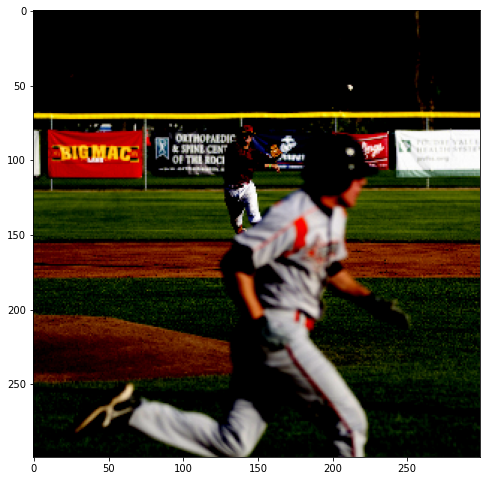

In [ ]:
# an_image = process_an_image("http://images.cocodataset.org/train2017/000000156510.jpg")


a_key = list(dataset.keys())[0]
img_location= a_key
captions = dataset[a_key]
print(img_location,"\n", captions)


imgdata = process_an_image(a_key)

print(imgdata.shape)

plt.imshow(imgdata[0])


In [ ]:
# def create_sequences2(tokenizer, max_length, desc_list):
#   X2, y = list(), list()
    
#     # walk through each description for the image
#   for desc in desc_list:
        
#         # encode the sequence
#     seq = tokenizer.texts_to_sequences([desc])[0]

#     # split one sequence into multiple X,y pairs
#     for i in range(1, len(seq)):

#       # split into input and output pair
#       in_seq, out_seq = seq[:i], seq[i]

#       # pad input sequence
#       in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

#       # encode output sequence
#       out_seq = to_categorical([out_seq], num_classes=total_words)[0]

#       # store

#       X2.append(in_seq)  # Caption input
#       y.append(out_seq)  # Caption output

#   return  np.array(X2), np.array(y)


# create_sequences2(tokenizer, max_length, captions)


In [ ]:

# def data_generator2(descriptions, tokenizer, max_length):
#   while 1:
#     for key, description_list in descriptions.items():
#       print(key,description_list)
#       input_image = process_an_image(key)
#       input_sequence, output_word = create_sequences2(tokenizer, max_length, description_list)
#       print(input_image.shape, input_sequence.shape, output_word.shape)
#     yield ([input_image, input_sequence], output_word)

# gen2 = data_generator2(dataset, tokenizer, max_length)

In [ ]:
# for i in gen2:
#   i

In [ ]:
# generator = data_generator(dataset, image_features, tokenizer, max_length)

# for i in generator:
#   i


In [ ]:

# def train_our_model(dataset):


#   print('Dataset: ', len(dataset))
#   print('Descriptions: train=', len(dataset))
#   print('Photos: train=', len(image_features))
#   print('Vocabulary Size:', total_words)
#   print('Description Length: ', max_length)

#   epochs=2
#   steps = len(dataset)

#   # making a directory models to save our models

  
#   for i in range(epochs):
#       generator = data_generator(dataset, image_features, tokenizer, max_length)
#       model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1)
#       model.save("models/model_" + str(i) + ".h5")


In [ ]:
# model =model1

# train_our_model(testsample_dict)

In [ ]:

# def train_our_model1(dataset,model = model1, tokenizer= tokenizer,max_length=max_length):


#   print('Dataset: ', len(dataset))
#   print('Descriptions: train=', len(dataset))
#   print('Photos: train=', len(image_features))
#   print('Vocabulary Size:', total_words)
#   print('Description Length: ', max_length)

#   epochs=2
#   steps = len(dataset)

#   # making a directory models to save our models

  
#   for i in range(epochs):
#       generator = data_generator(dataset, image_features, tokenizer, max_length)
#       model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1)
#       model.save("models/model_" + str(i) + ".h5")


In [ ]:
# train_our_model1(testsample_dict)

In [ ]:

# def train_our_model2(dataset,model = model):


#   print('Dataset: ', len(dataset))
#   print('Descriptions: train=', len(dataset))
#   # print('Photos: train=', len(image_features))
#   print('Vocabulary Size:', total_words)
#   print('Description Length: ', max_length)

#   epochs=1
#   steps = len(dataset)

#   # making a directory models to save our models

  
#   for i in range(epochs):
#       print(i)
#       gen2 = data_generator2(dataset, tokenizer, max_length)
#       print(1)

#       model.fit(gen2, epochs=1, steps_per_epoch= steps, verbose=1)
#       model.save("models/model_" + str(i) + ".h5")


In [ ]:
# train_our_model2(testsample_dict,model2)

In [ ]:
# train_our_model2(testsample_dict,model2)




In [ ]:
# model2.summary()

In [ ]:
# model1.name

In [ ]:
# model1.save("models/model1_f.h5")

In [ ]:
# # model_incep_lstm


# # os.mkdir(models)


  
# train_our_model(testsample_dict, model2)
# model2.name
# model2.save("models/model2_f.h5")

In [ ]:

# import numpy as np
# from PIL import Image
# import matplotlib.pyplot as plt
# import glob
# img_paths = []
# for filename in glob.glob('./drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/*.jpg'): #assuming jpg
#     # im=Image.open(filename)
#     # print(filename)
#     # print(im)
#     img_paths.append(filename)

#     if len(img_paths)>10:
#       break
# print(img_paths)


In [ ]:

# def extract_features(filename, model):
#         try:
#             image = Image.open(filename)

#         except:
#             print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
#         image = image.resize((299,299))
#         image = np.array(image)
        
#         # for images that has 4 channels, we convert them into 3 channels
#         if image.shape[2] == 4: 
#             image = image[..., :3]
#         image = np.expand_dims(image, axis=0)
#         image = image/127.5
#         image = image - 1.0
#         feature = model.predict(image)
#         return feature

# def word_for_id(integer, tokenizer):
#     for word, index in tokenizer.word_index.items():
#         if index == integer:
#             return word
#     return None


# def generate_desc(model, tokenizer, photo, max_length):
#     in_text = 'start'
#     for i in range(max_length):
#         sequence = tokenizer.texts_to_sequences([in_text])[0]
#         sequence = pad_sequences([sequence], maxlen=max_length)
#         pred = model.predict([photo,sequence], verbose=0)
#         pred = np.argmax(pred)
#         word = word_for_id(pred, tokenizer)
        
#         if word is None:
#             break
#         in_text += ' ' + word
        
#         if word == 'end':
#             break
#     return in_text


    


In [ ]:

# xception_model = Xception(include_top=False, pooling="avg")




In [ ]:
# print(max_length)
# print(model1.name)

# from keras.utils import plot_model
# plot_model(model1, to_file='model.png')


In [ ]:
# print(max_length)
# print(model2.name)

# from keras.utils import plot_model
# plot_model(model2, to_file='model.png')


In [ ]:
# photo = extract_features(img_paths[0], xception_model)
# img = Image.open(img_paths[0])
# description = generate_desc(model1, tokenizer, photo, max_length)
# print("\n\n")
# print(description)
# plt.imshow(img)

In [ ]:
# copy_model2 = load_model('./drive/MyDrive/3조/best_model.h5')
# copy_ssd = load_model('/content/drive/MyDrive/3조/ssd300.h5')

# copy_model2.summary()
# copy_ssd.summary()


In [ ]:
# plot_model(copy_ssd, to_file='model0.png')


In [ ]:
# plot_model(copy_model2, to_file='model1.png')


In [ ]:
# max_length =42
# generator = data_generator(dataset, image_features, tokenizer, max_length)


In [ ]:

# photo = extract_features(img_paths[0], copy_ssd)
# img = Image.open(img_paths[0])
# description = generate_desc(copy_model2, tokenizer, photo, 42)
# print("\n\n")
# print(description)
# plt.imshow(img)

In [ ]:

# photo = extract_features(img_paths[1], copy_ssd)
# img = Image.open(img_paths[1])
# description = generate_desc(copy_model2, tokenizer, photo, 42)
# print("\n\n")
# print(description)
# plt.imshow(img)

In [ ]:
import tensorflow as tf
import numpy as np
import json
from tqdm import tqdm
from sklearn.utils import shuffle

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import RepeatVector



def build_cnn_lstm(vocab_size, max_length, embedding_dim=256, units=256):
    # CNN Encoder (InceptionV3 pre-trained model)
    inception = InceptionV3(include_top=False, weights='imagenet', pooling='avg')
    for layer in inception.layers:
        layer.trainable = False

    input_image = Input(shape=(299, 299, 3))
    encoded_image = inception(input_image)
    encoded_image = Dense(embedding_dim, activation='relu')(encoded_image)
    encoded_image = Dropout(0.5)(encoded_image)
    encoded_image = BatchNormalization()(encoded_image)
    encoded_image = RepeatVector(max_length)(encoded_image)

    # LSTM Decoder
    input_caption = Input(shape=(max_length,))
    embedding = Embedding(vocab_size, embedding_dim)(input_caption)
    lstm_layer = LSTM(units, return_sequences=True)(embedding)
    lstm_layer = Dropout(0.5)(lstm_layer)
    lstm_layer = BatchNormalization()(lstm_layer)
    
    # Merge CNN and LSTM layers
    merged = Concatenate()([encoded_image, lstm_layer])

    # Dense layers
    decoder = LSTM(units, return_sequences=True)(merged)
    decoder = Dropout(0.5)(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = LSTM(units, return_sequences=False)(decoder)
    decoder = Dropout(0.5)(decoder)
    decoder = BatchNormalization()(decoder)
    output_caption = Dense(vocab_size, activation='softmax')(decoder)

    # Define the model
    model = Model(inputs=[input_image, input_caption], outputs=output_caption)

    return model
vocab_size = total_words  # Size of your vocabulary (adjust according to your dataset)
max_length = max_length  # Maximum length of a caption (adjust according to your dataset)
embedding_dim = 256  # Dimension of the word embeddings
units = 256  # Number of LSTM units

model = build_cnn_lstm(vocab_size, max_length, embedding_dim, units)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, 2048)         21802784    ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['inception_v3[0][0]']       

In [ ]:
def data_generator(images, captions, tokenizer, max_length, batch_size=10):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for img_path, img_captions in zip(images, captions):
            for caption in img_captions:
                n += 1

                # Preprocess image
                img = process_an_image(img_path)

                # Preprocess caption
                seq = tokenizer.texts_to_sequences([caption])[0]
                seq = pad_sequences([seq], maxlen=max_length, padding='post', truncating='post')[0]

                # Prepare input-output pairs
                for j in range(1, len(seq)):
                    in_seq, out_seq = seq[:j], seq[j]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(img)
                    X2.append(in_seq)
                    y.append(out_seq)

                if n == batch_size:
                    print(f"X1 shape: {np.array(X1).shape}, X2 shape: {np.array(X2).shape}, y shape: {np.array(y).shape}")
                    yield ([np.array(X1, dtype=object), np.array(X2, dtype=object)], np.array(y, dtype=object))
                    X1, X2, y = [], [], []
                    n = 0




In [ ]:
data_gen = data_generator(list(testsample_dict.keys()), list(testsample_dict.values()), tokenizer=sample_tokenizer, max_length=max_length)
iter = 0
for i in tqdm(data_gen, total=10):
    iter += 1
    if iter > 10:
        break

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-85-b22846ed2b04>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(f"X1 shape: {np.array(X1).shape}, X2 shape: {np.array(X2).shape}, y shape: {np.array(y).shape}")


X1 shape: (500, 1, 299, 299, 3), X2 shape: (500,), y shape: (500, 6429)


 10%|█         | 1/10 [00:19<02:51, 19.01s/it]

In [ ]:
data_gen = data_generator( list(testsample_dict.keys()),  list(testsample_dict.values()) ,tokenizer=sample_tokenizer,max_length=max_length)
iter = 0
for i in tqdm(data_gen):
  iter +=1
  if len(i >10:
    break

0it [00:00, ?it/s]

0
1 1 1
2 2 2
3 3 3
4 4 4
5 5 5
6 6 6
7 7 7
8 8 8
9 9 9
10 10 10
11 11 11
12 12 12
13 13 13
14 14 14
15 15 15
16 16 16
17 17 17
18 18 18
19 19 19
20 20 20
21 21 21
22 22 22
23 23 23
24 24 24
25 25 25
26 26 26
27 27 27
28 28 28
29 29 29
30 30 30
31 31 31
32 32 32
33 33 33
34 34 34
35 35 35
36 36 36
37 37 37
38 38 38
39 39 39
40 40 40
41 41 41
42 42 42
43 43 43
44 44 44
45 45 45
46 46 46
47 47 47
48 48 48
49 49 49
50 50 50
1
51 51 51
52 52 52
53 53 53
54 54 54
55 55 55
56 56 56
57 57 57
58 58 58
59 59 59
60 60 60
61 61 61
62 62 62
63 63 63
64 64 64
65 65 65
66 66 66
67 67 67
68 68 68
69 69 69
70 70 70
71 71 71
72 72 72
73 73 73
74 74 74
75 75 75
76 76 76
77 77 77
78 78 78
79 79 79
80 80 80
81 81 81
82 82 82
83 83 83
84 84 84
85 85 85
86 86 86
87 87 87
88 88 88
89 89 89
90 90 90
91 91 91
92 92 92
93 93 93
94 94 94
95 95 95
96 96 96
97 97 97
98 98 98
99 99 99
100 100 100
2
101 101 101
102 102 102
103 103 103
104 104 104
105 105 105
106 106 106
107 107 107
108 108 108
109 109 109
110 110 11

1it [00:23, 23.92s/it]

0
1 1 1
2 2 2
3 3 3
4 4 4
5 5 5
6 6 6
7 7 7
8 8 8
9 9 9
10 10 10
11 11 11
12 12 12
13 13 13
14 14 14
15 15 15
16 16 16
17 17 17
18 18 18
19 19 19
20 20 20
21 21 21
22 22 22
23 23 23
24 24 24
25 25 25
26 26 26
27 27 27
28 28 28
29 29 29
30 30 30
31 31 31
32 32 32
33 33 33
34 34 34
35 35 35
36 36 36
37 37 37
38 38 38
39 39 39
40 40 40
41 41 41
42 42 42
43 43 43
44 44 44
45 45 45
46 46 46
47 47 47
48 48 48
49 49 49
50 50 50
1
51 51 51
52 52 52
53 53 53
54 54 54
55 55 55
56 56 56
57 57 57
58 58 58
59 59 59
60 60 60
61 61 61
62 62 62
63 63 63
64 64 64
65 65 65
66 66 66
67 67 67
68 68 68
69 69 69
70 70 70
71 71 71
72 72 72
73 73 73
74 74 74
75 75 75
76 76 76
77 77 77
78 78 78
79 79 79
80 80 80
81 81 81
82 82 82
83 83 83
84 84 84
85 85 85
86 86 86
87 87 87
88 88 88
89 89 89
90 90 90
91 91 91
92 92 92
93 93 93
94 94 94
95 95 95
96 96 96
97 97 97
98 98 98
99 99 99
100 100 100
2
101 101 101
102 102 102
103 103 103
104 104 104
105 105 105
106 106 106
107 107 107
108 108 108
109 109 109
110 110 11

In [ ]:
train_images = list(testsample_dict.keys())

train_captions = list(testsample_dict.values())

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Set parameters
epochs = 2
batch_size = 10
steps_per_epoch = len(train_images) // batch_size

# Train the model
for i in tqdm(range(epochs)):
    generator = data_generator(train_images, train_captions, tokenizer, max_length)
    model.fit(generator, epochs=1, steps_per_epoch=steps_per_epoch, verbose=1)
    model.save('model_' + str(i) + '.h5')